# Fake News Detection

<img src="images/fake_news.jpg" alt="Drawing" style="width: 1000px;height:300px;float: left;"/>

## Summary
This prokect uses text data from over 114,000 articles to develop a text classification model that can accuractely identify fake news articles. The data consists of both fake and real news articles from numerous online publiocations such as Reuters and BuzzFeed. The model is being developed for a technology comapny that is looking to reduce misinformation on their platform. Doing so will imporve their customer experience, and reduce the possibility of any legal issues. The data was loaded and cleaned using the pandas library and split into training, testing, and validation datasets using sklearn. The training and validation sets were further split into smaller training and validation sets for faster processing on initial modeling iterations. The model uses classifiers from the sklearn library. After establishing a baseline model, multiple iterations are developed with different preprocessing and feature engineering techniques form the nltk library.

## Business Problem
A social media company is looking to reduce the sharing of misinformation on its platform. Having widespread misinformation on the platform may dicourage new users and may cause the platform to lose existing customers. Additionaly, reducing fake articles on the platform could remove any potential legal issues.

## Data Understanding
This project uses multiple datasets of over 102,000 articles from online publications such as Reuters and BuzzFeed. The data is balanced, having about 52% of the data being fake news articles.

In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
# load datasets
fake_or_real_df_1 = pd.read_csv('Data/WELFake_Dataset.csv')
fake_df_2 = pd.read_csv('Data/Fake.csv')
true_df_2 = pd.read_csv('Data/True.csv')

In [89]:
# preview first df
fake_or_real_df_1.head()

,text,label
0,No comment is expected from Barack Obama Membe...,1
1,Did they post their votes for Hillary already?,1
2,"Now, most of the demonstrators gathered last ...",1
3,A dozen politically active pastors came here f...,0
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [4]:
# preview second df
fake_df_2.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
# preview third df
true_df_2.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
# select desired columns from each dataframe and set label to string dtype
fake_or_real_df_1 = fake_or_real_df_1[['text', 'label']]
fake_or_real_df_1['label'] = fake_or_real_df_1['label'].astype(dtype='str')

fake_df_2 = fake_df_2[['text']]
true_df_2 = true_df_2[['text']]

fake_df_2['label'] = '0'
true_df_2['label'] = '1'

In [7]:
# combine all three datasets
fake_or_real_df = pd.concat([fake_or_real_df_1, fake_df_2, true_df_2])

In [8]:
# preview full dataset
fake_or_real_df.head()

,text,label
0,No comment is expected from Barack Obama Membe...,1
1,Did they post their votes for Hillary already?,1
2,"Now, most of the demonstrators gathered last ...",1
3,A dozen politically active pastors came here f...,0
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [9]:
# remove duplicate data points and missing value
fake_or_real_df.drop_duplicates(inplace=True)
fake_or_real_df.dropna(inplace=True)

In [10]:
# preview final full dataset
fake_or_real_df

,text,label
0,No comment is expected from Barack Obama Membe...,1
1,Did they post their votes for Hillary already?,1
2,"Now, most of the demonstrators gathered last ...",1
3,A dozen politically active pastors came here f...,0
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",1
21414,MINSK (Reuters) - In the shadow of disused Sov...,1
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [11]:
# check class balance
fake_or_real_df.label.value_counts(normalize=True)

0    0.513743
1    0.486257
Name: label, dtype: float64

Fake Articles:  52075
Real Articles:  49289


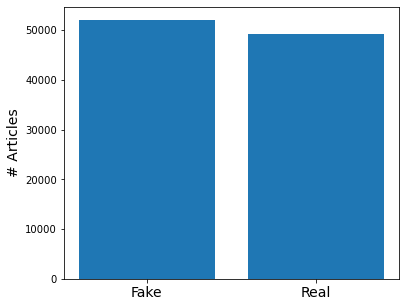

In [12]:
# plot the class distribution
counts = fake_or_real_df.label.value_counts()
fig, ax = plt.subplots(figsize=(6, 5))
plt.bar(['Fake', 'Real'], counts);
plt.ylabel('# Articles', fontsize=14);
plt.xticks(fontsize=14)
print("Fake Articles: ", counts[0])
print("Real Articles: ", counts[1])

## Data Preparation and Exploration
The case of the text data is standarized and toeknized. The frequency distributions of the data are examined. The data is then split into a train, test, and validation set. The training and validation sets are further split into more manegable subsets for faster processing during iniial modeling.

### Data Cleaning

In [13]:
# Transform  data to lowercase
fake_or_real_df['text'] = fake_or_real_df['text'].str.lower()

In [14]:
# Tokenize data
token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(token_pattern)

# create new column for tokenized data
fake_or_real_df['tokenized'] = fake_or_real_df['text'].apply(tokenizer.tokenize)

In [15]:
fake_or_real_df

,text,label,tokenized
0,no comment is expected from barack obama membe...,1,"[no, comment, is, expected, from, barack, obam..."
1,did they post their votes for hillary already?,1,"[did, they, post, their, votes, for, hillary, ..."
2,"now, most of the demonstrators gathered last ...",1,"[now, most, of, the, demonstrators, gathered, ..."
3,a dozen politically active pastors came here f...,0,"[dozen, politically, active, pastors, came, he..."
4,"the rs-28 sarmat missile, dubbed satan 2, will...",1,"[the, rs, 28, sarmat, missile, dubbed, satan, ..."
...,...,...,...
21412,brussels (reuters) - nato allies on tuesday we...,1,"[brussels, reuters, nato, allies, on, tuesday,..."
21413,"london (reuters) - lexisnexis, a provider of l...",1,"[london, reuters, lexisnexis, provider, of, le..."
21414,minsk (reuters) - in the shadow of disused sov...,1,"[minsk, reuters, in, the, shadow, of, disused,..."
21415,moscow (reuters) - vatican secretary of state ...,1,"[moscow, reuters, vatican, secretary, of, stat..."


### Data Splitting

In [16]:
# define featrues and target variables
X = fake_or_real_df[['text', 'tokenized']]
y = fake_or_real_df['label']

In [17]:
# intial split of data into traiing and test sets with 15% test size
X_train_1, X_test, y_train_1, y_test = train_test_split(X, y, test_size=.15, 
                                                        random_state=42)

In [18]:
# second split of data into training and validation sets with 15% val size
X_train, X_val, y_train, y_val = train_test_split(X_train_1, y_train_1, 
                                                  test_size=0.15,
                                                  random_state=42)

In [19]:
# third split of data into smaller training and val sets
X_train_sub, x1, y_train_sub, y1 = train_test_split(X_train, y_train, 
                                                  test_size=0.8,
                                                  random_state=42)

X_val_sub, x2, y_val_sub, y2 = train_test_split(X_val, y_val, 
                                                test_size=0.8,
                                                random_state=42)

In [20]:
#reset index of subsets
X_train_sub.reset_index(drop=True, inplace=True)
X_val_sub.reset_index(drop=True, inplace=True)

y_train_sub.reset_index(drop=True, inplace=True)
y_val_sub.reset_index(drop=True, inplace=True)

In [22]:
X_train_sub

,text,tokenized
0,washington (reuters) - republican presidential...,"[washington, reuters, republican, presidential..."
1,canada's liberal party won a decisive majority...,"[canada, liberal, party, won, decisive, majori..."
2,washington (reuters) - u.s. house speaker paul...,"[washington, reuters, house, speaker, paul, ry..."
3,hillary clinton has been gearing up for months...,"[hillary, clinton, has, been, gearing, up, for..."
4,"keywords: medical equipment , stethoscope fact...","[keywords, medical, equipment, stethoscope, fa..."
...,...,...
14642,just another slap in the face to us citizens. ...,"[just, another, slap, in, the, face, to, us, c..."
14643,"rancho mirage, calif. (reuters) - u.s. preside...","[rancho, mirage, calif, reuters, president, ba..."
14644,tokyo (reuters) - a typhoon roared towards jap...,"[tokyo, reuters, typhoon, roared, towards, jap..."
14645,washington (reuters) - libertarian party presi...,"[washington, reuters, libertarian, party, pres..."


### Exploratory Data Analysis

In [23]:
# define function for plotting top 10 words of freq dist
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

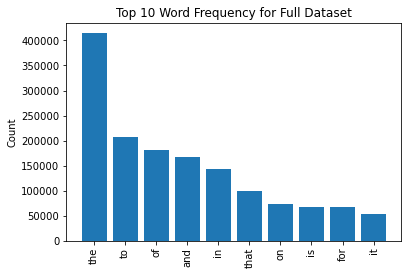

In [99]:
# top 10 words of training set
freq_dist = FreqDist(X_train_sub['tokenized'].explode())
visualize_top_10(freq_dist, "Top 10 Word Frequency for Full Dataset")

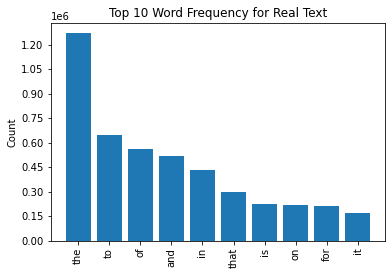

In [101]:
# top 10 words of real articles
true_freq_dist = FreqDist(fake_or_real_df.loc[fake_or_real_df.label == '1', 'tokenized'].explode())
visualize_top_10(true_freq_dist, "Top 10 Word Frequency for Real Text")

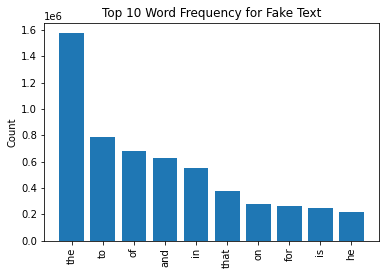

In [102]:
# top 20 words of fake articles
fake_freq_dist = FreqDist(fake_or_real_df.loc[fake_or_real_df.label == '0', 'tokenized'].explode())
visualize_top_10(fake_freq_dist, "Top 10 Word Frequency for Fake Text")

## Baseline Modeling
A baseline naive bayes tfidf model is developed for compariosn to furture iterations.

In [24]:
# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
baseline_tfidf = TfidfVectorizer(max_features=10)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized_baseline = baseline_tfidf.fit_transform(X_train_sub["text"])
X_val_vectorized_baseline = baseline_tfidf.fit_transform(X_val_sub["text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_baseline, columns=baseline_tfidf.get_feature_names())

C:\Users\bento\anaconda3.0\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,and,for,in,is,it,of,on,that,the,to
0,0.287328,0.000000,0.385180,0.107605,0.112481,0.000000,0.194577,0.000000,0.369076,0.755494
1,0.097035,0.053176,0.243902,0.000000,0.000000,0.483289,0.049284,0.155788,0.794597,0.191357
2,0.250313,0.195960,0.287622,0.000000,0.167984,0.249339,0.072647,0.114821,0.792340,0.282072
3,0.512523,0.187243,0.343533,0.115164,0.120383,0.306318,0.104123,0.036571,0.559590,0.370595
4,0.401498,0.097788,0.269115,0.300723,0.314350,0.266624,0.135946,0.095496,0.558705,0.395884
...,...,...,...,...,...,...,...,...,...,...
14642,0.080993,0.199731,0.142506,0.068247,0.071340,0.383222,0.061704,0.043344,0.838798,0.259548
14643,0.577328,0.079095,0.217671,0.000000,0.000000,0.359427,0.073306,0.077241,0.625712,0.284628
14644,0.292373,0.116525,0.160340,0.119448,0.249722,0.450091,0.269990,0.085345,0.563333,0.445531
14645,0.413043,0.090540,0.359910,0.092811,0.097017,0.164575,0.139855,0.088418,0.716254,0.325814


In [25]:
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized_baseline, y_train_sub)
baseline_cv

array([0.51331058, 0.51399317, 0.51621714, 0.51212018, 0.51348583])

In [26]:
# Instantiate a MultinomialNB classifier and fit to the vectorized data
baseline_model = MultinomialNB()
baseline_model.fit(X_train_vectorized_baseline, y_train_sub)

MultinomialNB()

In [27]:
# use model to training and validation labels
train_preds = baseline_model.predict(X_train_vectorized_baseline)
val_preds = baseline_model.predict(X_val_vectorized_baseline)

#calculate training and val accurcies
print("train acc: ", accuracy_score(y_train_sub, train_preds))
print("val acc: ", accuracy_score(y_val_sub, val_preds))

train acc:  0.513415716528982
val acc:  0.5054179566563467


Baseline model no better than random chance

## Model 2: Removing Stopwords
The next model will use data that has common stopwords removed that often have no impact on differntiating texts.

In [28]:
# dowload and define a list of stopwords using nltk library
nltk.download('stopwords', quiet=True)

stopwords_list = stopwords.words('english')

In [29]:
# define function to remove stopwords from tokenized data
def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [30]:
# remove stopwords from tokenized training data
X_train_sub["text_without_stopwords"] = X_train_sub["tokenized"].apply(remove_stopwords)

In [31]:
#add back label column to X_train_sub for freq dist analysis
X_train_sub["label"] = [y_train_sub[val] for val in X_train_sub.index]

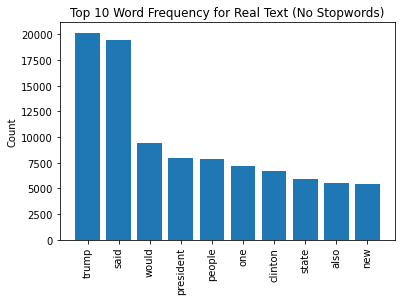

In [116]:
true_freq_dist = FreqDist(X_train_sub.loc[X_train_sub.label == '1', 'text_without_stopwords'].explode())
visualize_top_10(true_freq_dist, "Top 10 Word Frequency for Real Text (No Stopwords)")

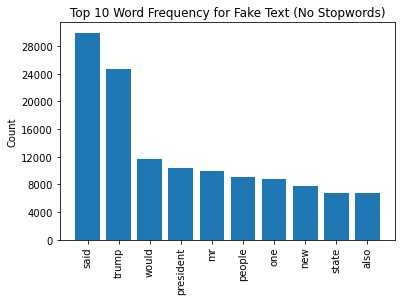

In [118]:
fake_freq_dist = FreqDist(X_train_sub.loc[X_train_sub.label == '0', 'text_without_stopwords'].explode())
visualize_top_10(fake_freq_dist, "Top 10 Word Frequency for Fake Text (No Stopwords)")

The fake and real distributions have similar words but in a different order.

In [120]:
# Instantiate the vectorizer
tfidf_2 = TfidfVectorizer(
    max_features=10,
    stop_words=stopwords_list
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized_2 = tfidf_2.fit_transform(X_train_sub["text"])
X_val_vectorized_2 = tfidf_2.fit_transform(X_val_sub["text"])
# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_2, columns=tfidf_2.get_feature_names())

C:\Users\bento\anaconda3.0\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,also,clinton,new,one,people,president,said,state,trump,would
0,0.000000,0.358152,0.000000,0.000000,0.238506,0.223434,0.523392,0.000000,0.700700,0.000000
1,0.281442,0.000000,0.301435,0.266784,0.000000,0.524137,0.613894,0.327365,0.000000,0.000000
2,0.402238,0.000000,0.000000,0.000000,0.000000,0.187275,0.877379,0.000000,0.000000,0.182589
3,0.061134,0.821240,0.000000,0.000000,0.121532,0.000000,0.000000,0.142219,0.535567,0.000000
4,0.000000,0.000000,0.000000,0.270630,0.567559,0.000000,0.000000,0.000000,0.000000,0.777584
...,...,...,...,...,...,...,...,...,...,...
14642,0.000000,0.000000,0.715747,0.158367,0.000000,0.466704,0.000000,0.194329,0.000000,0.455027
14643,0.000000,0.000000,0.411572,0.000000,0.000000,0.357822,0.838196,0.000000,0.000000,0.000000
14644,0.000000,0.000000,0.000000,0.638902,0.167486,0.000000,0.735085,0.000000,0.000000,0.152976
14645,0.000000,0.597972,0.143028,0.126586,0.132737,0.000000,0.679668,0.000000,0.259976,0.242475


In [121]:
# Instantiate a MultinomialNB classifier and fit to data
model_2 = MultinomialNB()
model_2.fit(X_train_vectorized_2, y_train_sub)

MultinomialNB()

In [122]:
# predict train and val labels and calculate accuracies
model_2_train_preds = model_2.predict(X_train_vectorized_2)
model_2_val_preds = model_2.predict(X_val_vectorized_2)

print("train acc: ", accuracy_score(y_train_sub, model_2_train_preds))
print("val acc: ", accuracy_score(y_val_sub, model_2_val_preds))

train acc:  0.5367652078924011
val acc:  0.5336687306501547


Marginal over baseline model

## Model 3: Stemming and Tokenization
The data for model three is stemmed and uses a new tokenizer in addition to removing stopwords.

In [82]:
# define stemmer
stemmer = SnowballStemmer(language="english")

# define fucntion to stem and tokenize
def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [83]:
# stem the stopwords list 
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [84]:
# Instantiate the vectorizer with stemming, tokeinzation, and stopword removal
tfidf_3 = TfidfVectorizer(
    max_features=10,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize
)

# Fit the vectorizer on X_train_sub text
X_train_vectorized_3 = tfidf_3.fit_transform(X_train_sub["text"])
X_val_vectorized_3 = tfidf_3.fit_transform(X_val_sub["text"])

# Visually inspect the vectorized data
#pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_3, columns=tfidf_3.get_feature_names())

In [128]:
# Instantiate a MultinomialNB classifier
model_3 = MultinomialNB()
model_3.fit(X_train_vectorized_3, y_train_sub)

MultinomialNB()

In [130]:
# predict labels and calculate accuracy
model_3_train_preds = model_3.predict(X_train_vectorized_3)
model_3_val_preds = model_3.predict(X_val_vectorized_3)

print("train acc: ", accuracy_score(y_train_sub, model_3_train_preds))
print("val acc: ", accuracy_score(y_val_sub, model_3_val_preds))

train acc:  0.5408616098859835
val acc:  0.538312693498452


Minimal improvement over model 2.

## Model 4: Increasing Max Features
Up until this point, we have developed the model only using the top 10 most frequent features. In this model, that is incresased to the top 200 features.

In [34]:
# Instantiate the vectorizer
tfidf_4 = TfidfVectorizer(
    max_features=None,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized_4 = tfidf_4.fit_transform(X_train_sub["text"])
X_val_vectorized_4 = tfidf_4.fit_transform(X_val_sub["text"])


# Create a full df of vectorized + engineered features
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_4, columns=tfidf_4.get_feature_names())

C:\Users\bento\anaconda3.0\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000,2016,accord,ad,administr,agenc,allow,also,america,american,...,week,well,whether,white,women,work,world,would,year,york
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.0,0.000000,0.117319,0.000000,0.0,0.078439,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.096084,0.000000,0.000000,0.154048,0.0
2,0.000000,0.000000,0.000000,0.0,0.072959,0.150500,0.000000,0.0,0.100624,0.0,...,0.0,0.0,0.066986,0.000000,0.0,0.000000,0.000000,0.045677,0.098809,0.0
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.051423,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.062991,0.148314,0.000000,0.050496,0.0
4,0.000000,0.106103,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.094451,0.000000,0.0,0.000000,0.102303,0.193214,0.139322,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14642,0.168373,0.000000,0.071516,0.0,0.000000,0.079786,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.145291,0.000000,0.0
14643,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
14644,0.196495,0.000000,0.000000,0.0,0.000000,0.000000,0.420803,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.104967,0.0,0.000000,0.000000,0.056519,0.000000,0.0
14645,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.087237,0.0,0.000000,0.000000,0.093945,0.050806,0.0


In [85]:
# Instantiate a MultinomialNB classifier
model_4 = MultinomialNB()
model_4.fit(X_train_vectorized_4, y_train_sub)

MultinomialNB()

In [86]:
# predict labels and calculate accuracy
model_4_train_preds = model_4.predict(X_train_vectorized_4)
model_4_val_preds = model_4.predict(X_val_vectorized_4)

print("train acc: ", accuracy_score(y_train_sub, model_4_train_preds))
print("val acc: ", accuracy_score(y_val_sub, model_4_val_preds))

train acc:  0.5813477162558885
val acc:  0.5406346749226006


Minimal accuracy increase

## Model 5: POS Tag

In [90]:
# define fucntion to convert to POS Tag
def stem_tokenize_tag(document):
    tokens = tokenizer.tokenize(document)
    stem_tokens = [stemmer.stem(token) for token in tokens]
    return pos_tag(stem_tokens)

In [77]:
# Instantiate the vectorizer
tfidf_5 = TfidfVectorizer(
    max_features=200,
    stop_words=stemmed_stopwords,
    tokenizer=stem_tokenize_tag
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized_5 = tfidf_5.fit_transform(X_train_sub["text"])
X_val_vectorized_5 = tfidf_5.fit_transform(X_val_sub["text"])


# Create a full df of vectorized + engineered features
#pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_5, columns=tfidf_5.get_feature_names())

C:\Users\bento\anaconda3.0\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [('about', 'IN'), ('abov', 'NN'), ('after', 'IN'), ('again', 'RB'), ('against', 'IN'), ('ain', 'NN'), ('all', 'DT'), ('am', 'VBP'), ('an', 'DT'), ('and', 'CC'), ('ani', 'NN'), ('are', 'VBP'), ('aren', 'NNS'), ('as', 'IN'), ('at', 'IN'), ('be', 'VB'), ('becaus', 'NN'), ('been', 'VBN'), ('befor', 'NN'), ('below', 'IN'), ('between', 'IN'), ('both', 'DT'), ('but', 'CC'), ('by', 'IN'), ('can', 'MD'), ('couldn', 'NN'), ('did', 'VBD'), ('didn', 'NN'), ('do', 'VB'), ('doe', 'NN'), ('doesn', 'NN'), ('don', 'NN'), ('down', 'RB'), ('dure', 'NN'), ('each', 'DT'), ('few', 'JJ'), ('for', 'IN'), ('from', 'IN'), ('further', 'RB'), ('had', 'VBD'), ('hadn', 'NN'), ('has', 'VBZ'), ('hasn', 'NN'), ('have', 'VB'), ('haven', 'NN'), ('he', 'PRP'), ('her', 'PRP$'), ('here', 'RB'), ('herself', 'NN'), ('him', 'PR

,"(000, CD)","(2016, CD)","(about, IN)","(accord, NN)","(ad, NN)","(administr, NN)","(after, IN)","(against, IN)","(all, DT)","(also, RB)",...,"(who, WP)","(will, MD)","(with, IN)","(women, NNS)","(work, NN)","(world, NN)","(would, MD)","(year, NN)","(you, PRP)","(your, PRP$)"
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.083641,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.0,0.000000,0.083066,0.000000,0.000000,0.055717,0.053132,...,0.000000,0.000000,0.255095,0.0,0.074178,0.000000,0.000000,0.104346,0.000000,0.000000
2,0.000000,0.000000,0.037544,0.0,0.060266,0.129948,0.039561,0.000000,0.000000,0.083118,...,0.000000,0.000000,0.085514,0.0,0.000000,0.000000,0.037730,0.081619,0.000000,0.000000
3,0.000000,0.000000,0.060931,0.0,0.000000,0.000000,0.000000,0.121268,0.035365,0.033724,...,0.000000,0.000000,0.023131,0.0,0.047082,0.097265,0.000000,0.033115,0.000000,0.000000
4,0.000000,0.068757,0.041496,0.0,0.000000,0.000000,0.000000,0.000000,0.048168,0.000000,...,0.000000,0.000000,0.094515,0.0,0.000000,0.066240,0.125104,0.090209,0.000000,0.074647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14642,0.091779,0.000000,0.000000,0.0,0.000000,0.045461,0.083040,0.069708,0.000000,0.000000,...,0.023836,0.053232,0.019944,0.0,0.000000,0.000000,0.079197,0.000000,0.031865,0.000000
14643,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.097161,0.000000,...,0.000000,0.000000,0.063549,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14644,0.106480,0.000000,0.000000,0.0,0.000000,0.000000,0.032114,0.000000,0.035377,0.000000,...,0.000000,0.030879,0.046278,0.0,0.000000,0.000000,0.030627,0.000000,0.000000,0.000000
14645,0.000000,0.000000,0.214627,0.0,0.000000,0.000000,0.064616,0.000000,0.000000,0.000000,...,0.000000,0.031066,0.023279,0.0,0.000000,0.000000,0.061626,0.033328,0.148772,0.000000


In [78]:
# Instantiate a MultinomialNB classifier
model_5 = MultinomialNB()
model_5.fit(X_train_vectorized_5, y_train_sub)

MultinomialNB()

In [91]:
# predict labels and calculate accuracy
model_5_train_preds = model_5.predict(X_train_vectorized_5)
model_5_val_preds = model_5.predict(X_val_vectorized_5)

print("train acc: ", accuracy_score(y_train_sub, model_5_train_preds))
print("val acc: ", accuracy_score(y_val_sub, model_5_val_preds))

train acc:  0.5817573564552468
val acc:  0.5603715170278638


Best accuracy thus far

## Vectorization Strategy
Thus far, we have vectorized the data using on the Tdidf vectorizer. Here, we try some different options.

### Count Vectorizer

In [93]:
# Instantiate the vectorizer
count_vec_6 = CountVectorizer(
    max_features=200,
    stop_words=stemmed_stopwords,
    tokenizer=stem_tokenize_tag
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized_6 = count_vec_6.fit_transform(X_train_sub["text"])
X_val_vectorized_6 = count_vec_6.fit_transform(X_val_sub["text"])


# Create a full df of vectorized + engineered features
#pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_6, columns=count_vec_6.get_feature_names())

C:\Users\bento\anaconda3.0\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [('about', 'IN'), ('abov', 'NN'), ('after', 'IN'), ('again', 'RB'), ('against', 'IN'), ('ain', 'NN'), ('all', 'DT'), ('am', 'VBP'), ('an', 'DT'), ('and', 'CC'), ('ani', 'NN'), ('are', 'VBP'), ('aren', 'NNS'), ('as', 'IN'), ('at', 'IN'), ('be', 'VB'), ('becaus', 'NN'), ('been', 'VBN'), ('befor', 'NN'), ('below', 'IN'), ('between', 'IN'), ('both', 'DT'), ('but', 'CC'), ('by', 'IN'), ('can', 'MD'), ('couldn', 'NN'), ('did', 'VBD'), ('didn', 'NN'), ('do', 'VB'), ('doe', 'NN'), ('doesn', 'NN'), ('don', 'NN'), ('down', 'RB'), ('dure', 'NN'), ('each', 'DT'), ('few', 'JJ'), ('for', 'IN'), ('from', 'IN'), ('further', 'RB'), ('had', 'VBD'), ('hadn', 'NN'), ('has', 'VBZ'), ('hasn', 'NN'), ('have', 'VB'), ('haven', 'NN'), ('he', 'PRP'), ('her', 'PRP$'), ('here', 'RB'), ('herself', 'NN'), ('him', 'PR

In [94]:
# Instantiate a MultinomialNB classifier
model_6 = MultinomialNB()
model_6.fit(X_train_vectorized_6, y_train_sub)

MultinomialNB()

In [95]:
# predict labels and calculate accuracy
model_6_train_preds = model_6.predict(X_train_vectorized_6)
model_6_val_preds = model_6.predict(X_val_vectorized_6)

print("train acc: ", accuracy_score(y_train_sub, model_6_train_preds))
print("val acc: ", accuracy_score(y_val_sub, model_6_val_preds))

train acc:  0.5618215334198129
val acc:  0.5468266253869969


Tfidf vectorized produced better results

## Classifiers

### Support Vector Machine

In [96]:
svm = SVC(kernel='linear').fit(X_train_vectorized_5, y_train_sub)

In [97]:
svm_train_preds = svm.predict(X_train_vectorized_5)
svm_val_preds = svm.predict(X_val_vectorized_5)
print("val acc: ", accuracy_score(y_val_sub, svm_val_preds))
print("train acc: ", accuracy_score(y_train_sub, svm_train_preds))

val acc:  0.5688854489164087
train acc:  0.6037413804874718


### Random Forest

In [98]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train_vectorized_5, y_train_sub)

RandomForestClassifier(max_depth=2, random_state=0)

In [99]:
rf_train_preds = rf.predict(X_train_vectorized_5)
rf_val_preds = rf.predict(X_val_vectorized_5)
print("val acc: ", accuracy_score(y_val_sub, rf_val_preds))
print("train acc: ", accuracy_score(y_train_sub, rf_train_preds))

val acc:  0.5421826625386997
train acc:  0.5681026831433058


### XGBoost

In [102]:
#instantiate a baseline XGBoost Classifier
xgb = XGBClassifier()
xgb.fit(X_train_vectorized_5, y_train_sub)

C:\Users\bento\anaconda3.0\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:23:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [103]:
xgb_train_preds = xgb.predict(X_train_vectorized_5)
xgb_val_preds = xgb.predict(X_val_vectorized_5)
print("val acc: ", accuracy_score(y_val_sub, xgb_val_preds))
print("train acc: ", accuracy_score(y_train_sub, xgb_train_preds))

val acc:  0.528250773993808
train acc:  0.9146582918003687


In [106]:
#instantiate a baseline XGBoost Classifier
xgb2 = XGBClassifier(subsample=0.5)
xgb2.fit(X_train_vectorized_5, y_train_sub)

C:\Users\bento\anaconda3.0\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:32:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [107]:
xgb2_train_preds = xgb2.predict(X_train_vectorized_5)
xgb2_val_preds = xgb2.predict(X_val_vectorized_5)
print("val acc: ", accuracy_score(y_val_sub, xgb2_val_preds))
print("train acc: ", accuracy_score(y_train_sub, xgb2_train_preds))

val acc:  0.5224458204334366
train acc:  0.8818188024851505


In [ ]:
#define parameter grid for search
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [2,4,6],
    'min_child_weight': [1, 2],
    'subsample': [0.2, 0.7],
    'n_estimators': [100],
}

#insantiate and fit search object
grid_xgb = GridSearchCV(xgb,
                        xgb_param_grid,
                        scoring='accuracy',
                        cv=3, n_jobs=1,
                        refit='accuracy',
                        return_train_score=True)

grid_xgb.fit(X_train_vectorized_5, y_train_sub)

#print best parameters
best_parameters = grid_xgb.best_params_
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

In [ ]:
X_train_vectorized_5

### Neural Netwrok

## Final Evaluation

## Conclusion

## Next Steps